이제 데이터셋에 맞게 불러온 모델을 변경하여 학습해봅시다

https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.models as models

path = '/content/drive/MyDrive/Teaching/DL 202301/Cats'

train_data = datasets.ImageFolder(path + '/train', transform = transforms.ToTensor())
valid_data = datasets.ImageFolder(path + '/valid', transform = transforms.ToTensor())
test_data = datasets.ImageFolder(path + '/test', transform = transforms.ToTensor())

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle =True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

https://pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v3_small.html#torchvision.models.MobileNet_V3_Small_Weights

모바일넷을 불러오는데, 이번에는 학습된 weight을 가져오겠습니다 .



In [2]:
model = models.mobilenet_v3_small(weights='IMAGENET1K_V1', pretrained=True)  
#model = models.mobilenet_v3_small(weights='DEFAULT')   # 이렇게 적어도 동일합니다. 

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [4]:
from torchsummary import summary
summary(model, (3, 224, 224))  

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14           [-1, 16,

기존 레이어들을 그대로 두고 마지막 레이어를 현재 데이터셋에 맞게 10개의 분류를 할 수 있게 변경해야 합니다. 

레이어에 접근은 모델 프린트를 보고 찾을 수 있습니다. 


In [5]:
model.classifier

Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=1000, bias=True)
)

In [6]:
model.classifier[-1]  # 마지막 레이어이므로 -1로 지정 가능능
#model.classifier[3]   # 직접 번호를 지정해도 됨됨

Linear(in_features=1024, out_features=1000, bias=True)

In [7]:
type(model.classifier)

torch.nn.modules.container.Sequential

In [8]:
model.features[0]

Conv2dNormActivation(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  (2): Hardswish()
)

In [9]:
model.features[0][2]

Hardswish()

Transfer Learning 에서는 기존 학습된 파라미터를 활용하는데, 여기에서는 모든 레이어를 학습하지 않게하고 마지막 레이어를 변경하겠습니다. 

In [10]:
for param in model.parameters():  
  param.requires_grad = False   # 모든 층의 파라미터를 학습하지 않도록 합니다. 
  # print(param)   # 출력해보면 Tensor들이 보여집니다. 

In [11]:
num_ftrs = model.classifier[-1].in_features  # 마지막 층의 입력 feature 개수를 추출합니다. 
model.classifier[-1] = nn.Linear(num_ftrs, 10)  # 최종으로 분류할 클래스 개수로 새로 지정합니다. 
model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

모델의 파라미터가 학습되지 않게 변경되었는지 확인해봅시다

In [12]:
from torchsummary import summary
summary(model, (3, 224, 224))  

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14           [-1, 16,

이제 학습을 해봅시다. 

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [14]:
from tqdm import tqdm

size = len(train_loader.dataset)  # 데이터셋 길이 확인
model.train()   # 모델을 훈련모드로 

epochs = 30
losses = []  # epoch마다 loss 변화 저장 변수
acces = []  # epoch마다 acc변화 저장 변수
losses_val = []  # epoch마다 loss 변화 저장 변수, valid_dataset
acces_val = []  # epoch마다 acc변화 저장 변수

for i in range(epochs):

  model.train() # 학습 모드
  train_loss, correct = 0, 0  # loss와 정확도 계산 목적
  for X, y in tqdm(train_loader): # tqdm으로 진행상황 확인 가능
      X, y = X.to(device), y.to(device) 

      # Compute prediction error
      pred = model(X)  # 예측 계산
      loss = loss_fn(pred, y)  # loss 계산
      train_loss += loss.item()  # loss 누적
      correct += (pred.argmax(1) == y).sum()  # 맞춘 개수 확인

      # Backpropagation
      optimizer.zero_grad()  # gradient 초기화
      loss.backward()   # gradient 계산
      optimizer.step()   # w,b 반영

  # train 데이터셋에 대한 정확도 계산                
  acc = correct/size  
  losses.append(loss.item())
  acces.append(acc.item())
  print('epoch:',i+1)
  print(f"loss: {train_loss:>7f}  acc:{acc:>5f}")

  # 에포크 마다, validation 데이터셋 정확도 계산
  valid_loss = 0
  valid_correct = 0

  model.eval()  # 평가용 모드
  with torch.no_grad(): 
    for x_val, y_val in valid_loader:  # vaildation set에서 정확도 평가
      x_val, y_val = x_val.to(device), y_val.to(device) 
      pred_val = model(x_val)
      valid_loss += loss_fn(pred_val, y_val).item()
      print(pred_val.shape, pred_val.argmax(1))
      valid_correct += (pred_val.argmax(1) == y_val).sum().item()

      break # 1개의 배치만 테스트(시간 때문에)

    valid_acc = valid_correct/(batch_size)  
    losses_val.append(valid_loss)
    acces_val.append(valid_acc)
    print(f"val_loss: {valid_loss:>7f}  val_acc:{valid_acc:>5f}")



100%|██████████| 74/74 [10:25<00:00,  8.45s/it]


epoch: 1
loss: 92.396118  acc:0.670799
torch.Size([32, 10]) tensor([8, 0, 3, 4, 1, 8, 0, 8, 2, 6, 1, 7, 7, 9, 4, 5, 4, 8, 6, 7, 2, 0, 2, 5,
        2, 0, 4, 7, 5, 4, 6, 0], device='cuda:0')
val_loss: 0.567235  val_acc:0.843750


100%|██████████| 74/74 [00:08<00:00,  8.26it/s]


epoch: 2
loss: 44.580365  acc:0.853356
torch.Size([32, 10]) tensor([0, 8, 0, 0, 7, 0, 4, 7, 7, 1, 7, 9, 4, 0, 5, 0, 7, 2, 0, 6, 1, 6, 7, 3,
        3, 1, 6, 8, 3, 0, 0, 3], device='cuda:0')
val_loss: 0.649031  val_acc:0.718750


100%|██████████| 74/74 [00:08<00:00,  8.68it/s]


epoch: 3
loss: 35.313072  acc:0.876443
torch.Size([32, 10]) tensor([7, 5, 9, 4, 0, 9, 3, 2, 9, 4, 9, 1, 8, 3, 7, 7, 0, 7, 3, 8, 1, 6, 0, 2,
        0, 7, 6, 8, 2, 1, 5, 5], device='cuda:0')
val_loss: 0.493245  val_acc:0.843750


100%|██████████| 74/74 [00:08<00:00,  8.69it/s]


epoch: 4
loss: 30.831066  acc:0.897820
torch.Size([32, 10]) tensor([7, 0, 4, 3, 8, 7, 5, 2, 0, 2, 0, 5, 6, 6, 0, 8, 9, 0, 5, 3, 8, 7, 6, 0,
        0, 7, 1, 0, 0, 8, 1, 4], device='cuda:0')
val_loss: 0.598145  val_acc:0.750000


100%|██████████| 74/74 [00:08<00:00,  8.25it/s]


epoch: 5
loss: 25.592807  acc:0.915348
torch.Size([32, 10]) tensor([3, 8, 7, 8, 4, 0, 2, 7, 0, 5, 5, 6, 3, 6, 1, 1, 0, 4, 0, 7, 0, 7, 8, 2,
        2, 7, 1, 3, 6, 4, 9, 8], device='cuda:0')
val_loss: 0.262683  val_acc:0.937500


100%|██████████| 74/74 [00:09<00:00,  8.22it/s]


epoch: 6
loss: 24.157627  acc:0.925182
torch.Size([32, 10]) tensor([7, 7, 0, 6, 0, 3, 1, 3, 2, 4, 6, 7, 4, 9, 7, 3, 0, 1, 1, 1, 6, 7, 9, 2,
        8, 5, 9, 0, 8, 9, 8, 4], device='cuda:0')
val_loss: 0.413933  val_acc:0.781250


100%|██████████| 74/74 [00:08<00:00,  8.82it/s]


epoch: 7
loss: 21.323328  acc:0.937153
torch.Size([32, 10]) tensor([7, 5, 2, 6, 4, 2, 5, 3, 8, 4, 2, 4, 9, 3, 1, 6, 4, 0, 2, 0, 9, 5, 7, 7,
        3, 6, 0, 4, 4, 2, 5, 5], device='cuda:0')
val_loss: 0.342734  val_acc:0.875000


100%|██████████| 74/74 [00:08<00:00,  8.38it/s]


epoch: 8
loss: 21.788036  acc:0.934160
torch.Size([32, 10]) tensor([0, 8, 4, 8, 6, 7, 7, 0, 1, 8, 5, 2, 2, 9, 8, 0, 0, 6, 7, 4, 7, 9, 5, 0,
        5, 1, 2, 3, 5, 3, 1, 3], device='cuda:0')
val_loss: 0.462276  val_acc:0.843750


100%|██████████| 74/74 [00:09<00:00,  8.20it/s]


epoch: 9
loss: 18.500177  acc:0.935443
torch.Size([32, 10]) tensor([8, 7, 6, 1, 3, 9, 3, 8, 9, 7, 9, 0, 4, 1, 7, 0, 0, 5, 5, 8, 8, 0, 1, 5,
        3, 0, 1, 2, 9, 4, 6, 2], device='cuda:0')
val_loss: 0.170806  val_acc:0.937500


100%|██████████| 74/74 [00:08<00:00,  8.89it/s]


epoch: 10
loss: 17.450307  acc:0.944848
torch.Size([32, 10]) tensor([0, 0, 7, 9, 7, 1, 4, 9, 6, 8, 1, 2, 2, 3, 5, 8, 3, 6, 4, 7, 5, 0, 0, 8,
        7, 0, 4, 8, 1, 6, 3, 0], device='cuda:0')
val_loss: 0.190740  val_acc:0.906250


100%|██████████| 74/74 [00:09<00:00,  8.15it/s]


epoch: 11
loss: 15.405377  acc:0.944421
torch.Size([32, 10]) tensor([8, 7, 6, 5, 0, 3, 6, 1, 4, 9, 8, 7, 5, 7, 5, 8, 3, 1, 7, 0, 6, 5, 0, 3,
        1, 0, 0, 3, 2, 0, 4, 7], device='cuda:0')
val_loss: 0.337537  val_acc:0.843750


100%|██████████| 74/74 [00:09<00:00,  8.22it/s]


epoch: 12
loss: 16.649430  acc:0.950834
torch.Size([32, 10]) tensor([3, 8, 7, 7, 9, 7, 1, 8, 7, 1, 3, 6, 8, 4, 8, 1, 6, 9, 8, 5, 2, 0, 1, 7,
        5, 4, 5, 0, 0, 0, 9, 0], device='cuda:0')
val_loss: 0.349944  val_acc:0.906250


100%|██████████| 74/74 [00:08<00:00,  8.87it/s]


epoch: 13
loss: 14.545103  acc:0.949979
torch.Size([32, 10]) tensor([5, 4, 9, 7, 7, 4, 5, 0, 3, 6, 4, 0, 8, 8, 7, 6, 2, 2, 9, 5, 0, 8, 3, 7,
        3, 1, 1, 0, 4, 5, 0, 8], device='cuda:0')
val_loss: 0.463673  val_acc:0.812500


100%|██████████| 74/74 [00:08<00:00,  8.27it/s]


epoch: 14
loss: 13.243321  acc:0.961950
torch.Size([32, 10]) tensor([4, 4, 0, 1, 9, 3, 5, 0, 6, 4, 1, 0, 3, 5, 2, 9, 7, 0, 7, 0, 5, 6, 0, 6,
        7, 2, 4, 5, 3, 1, 7, 1], device='cuda:0')
val_loss: 0.364212  val_acc:0.843750


100%|██████████| 74/74 [00:08<00:00,  8.25it/s]


epoch: 15
loss: 13.074770  acc:0.955109
torch.Size([32, 10]) tensor([4, 0, 4, 2, 3, 0, 7, 0, 3, 5, 6, 5, 2, 1, 4, 8, 6, 9, 2, 4, 3, 8, 3, 9,
        5, 9, 0, 9, 8, 0, 3, 0], device='cuda:0')
val_loss: 0.458738  val_acc:0.812500


100%|██████████| 74/74 [00:08<00:00,  8.75it/s]


epoch: 16
loss: 12.663610  acc:0.970073
torch.Size([32, 10]) tensor([7, 0, 4, 6, 2, 6, 6, 5, 9, 2, 7, 5, 7, 0, 4, 4, 8, 0, 8, 3, 1, 9, 4, 1,
        7, 9, 4, 3, 3, 8, 6, 0], device='cuda:0')
val_loss: 0.314575  val_acc:0.843750


100%|██████████| 74/74 [00:08<00:00,  8.34it/s]


epoch: 17
loss: 12.084549  acc:0.958957
torch.Size([32, 10]) tensor([5, 2, 5, 1, 6, 1, 9, 6, 4, 0, 3, 7, 1, 3, 8, 5, 4, 8, 3, 9, 8, 9, 3, 2,
        0, 3, 4, 0, 0, 2, 9, 6], device='cuda:0')
val_loss: 0.463182  val_acc:0.812500


100%|██████████| 74/74 [00:08<00:00,  8.32it/s]


epoch: 18
loss: 11.893559  acc:0.956392
torch.Size([32, 10]) tensor([9, 7, 5, 5, 6, 3, 0, 0, 6, 8, 0, 8, 0, 3, 9, 7, 9, 0, 3, 7, 1, 1, 2, 5,
        3, 2, 0, 0, 0, 8, 9, 5], device='cuda:0')
val_loss: 0.437602  val_acc:0.843750


100%|██████████| 74/74 [00:08<00:00,  8.76it/s]


epoch: 19
loss: 11.088610  acc:0.964942
torch.Size([32, 10]) tensor([7, 4, 3, 8, 4, 5, 5, 7, 0, 0, 9, 7, 9, 2, 2, 9, 1, 9, 3, 1, 2, 3, 6, 4,
        0, 5, 9, 7, 6, 8, 6, 6], device='cuda:0')
val_loss: 0.280472  val_acc:0.843750


100%|██████████| 74/74 [00:08<00:00,  8.23it/s]


epoch: 20
loss: 11.386867  acc:0.969218
torch.Size([32, 10]) tensor([6, 4, 0, 7, 3, 3, 4, 4, 1, 3, 8, 9, 4, 1, 8, 1, 7, 6, 0, 5, 4, 8, 9, 4,
        7, 9, 2, 2, 0, 9, 2, 3], device='cuda:0')
val_loss: 0.429663  val_acc:0.843750


100%|██████████| 74/74 [00:08<00:00,  8.28it/s]


epoch: 21
loss: 10.306521  acc:0.960667
torch.Size([32, 10]) tensor([0, 6, 2, 8, 2, 1, 9, 1, 3, 0, 0, 2, 7, 5, 7, 1, 3, 9, 4, 0, 5, 2, 0, 9,
        8, 3, 3, 9, 5, 7, 2, 6], device='cuda:0')
val_loss: 0.334652  val_acc:0.875000


100%|██████████| 74/74 [00:08<00:00,  8.85it/s]


epoch: 22
loss: 10.462013  acc:0.966225
torch.Size([32, 10]) tensor([2, 5, 7, 2, 9, 3, 0, 9, 3, 3, 7, 0, 2, 9, 7, 5, 2, 0, 9, 3, 8, 2, 3, 0,
        1, 8, 1, 8, 4, 4, 9, 1], device='cuda:0')
val_loss: 0.317287  val_acc:0.875000


100%|██████████| 74/74 [00:08<00:00,  8.24it/s]


epoch: 23
loss: 10.010653  acc:0.962377
torch.Size([32, 10]) tensor([0, 3, 8, 4, 8, 1, 8, 0, 9, 0, 6, 7, 1, 0, 2, 7, 2, 0, 4, 1, 5, 4, 3, 0,
        8, 6, 9, 5, 5, 5, 4, 8], device='cuda:0')
val_loss: 0.370832  val_acc:0.875000


100%|██████████| 74/74 [00:08<00:00,  8.23it/s]


epoch: 24
loss: 9.950663  acc:0.972638
torch.Size([32, 10]) tensor([4, 5, 1, 8, 0, 4, 0, 9, 0, 3, 8, 0, 6, 4, 6, 6, 3, 0, 1, 5, 3, 9, 1, 6,
        8, 2, 4, 5, 3, 8, 3, 8], device='cuda:0')
val_loss: 0.322363  val_acc:0.843750


100%|██████████| 74/74 [00:08<00:00,  8.56it/s]


epoch: 25
loss: 11.175543  acc:0.967080
torch.Size([32, 10]) tensor([6, 1, 5, 8, 8, 3, 7, 4, 7, 5, 6, 8, 8, 0, 4, 0, 0, 3, 9, 0, 7, 3, 9, 1,
        2, 3, 7, 6, 5, 6, 0, 1], device='cuda:0')
val_loss: 0.409919  val_acc:0.843750


100%|██████████| 74/74 [00:09<00:00,  8.14it/s]


epoch: 26
loss: 8.780895  acc:0.973065
torch.Size([32, 10]) tensor([1, 9, 5, 4, 0, 7, 0, 6, 6, 1, 8, 0, 8, 0, 9, 5, 0, 9, 0, 7, 8, 2, 6, 4,
        3, 8, 9, 0, 2, 3, 2, 2], device='cuda:0')
val_loss: 0.389641  val_acc:0.843750


100%|██████████| 74/74 [00:08<00:00,  8.24it/s]


epoch: 27
loss: 9.477126  acc:0.968790
torch.Size([32, 10]) tensor([3, 9, 2, 5, 7, 2, 6, 2, 4, 9, 0, 4, 9, 2, 0, 7, 8, 5, 0, 6, 8, 5, 5, 1,
        9, 9, 0, 7, 1, 3, 0, 1], device='cuda:0')
val_loss: 0.287002  val_acc:0.906250


100%|██████████| 74/74 [00:08<00:00,  8.83it/s]


epoch: 28
loss: 8.785655  acc:0.968363
torch.Size([32, 10]) tensor([2, 0, 9, 3, 8, 0, 8, 7, 8, 6, 0, 6, 1, 2, 4, 0, 6, 7, 1, 5, 7, 5, 9, 0,
        9, 9, 2, 0, 1, 3, 9, 5], device='cuda:0')
val_loss: 0.450520  val_acc:0.812500


100%|██████████| 74/74 [00:09<00:00,  8.18it/s]


epoch: 29
loss: 8.634793  acc:0.968790
torch.Size([32, 10]) tensor([9, 5, 7, 6, 9, 2, 1, 5, 5, 4, 1, 3, 1, 0, 7, 0, 0, 2, 2, 4, 2, 6, 0, 7,
        8, 0, 8, 0, 9, 3, 3, 8], device='cuda:0')
val_loss: 0.426806  val_acc:0.843750


100%|██████████| 74/74 [00:08<00:00,  8.35it/s]


epoch: 30
loss: 8.000684  acc:0.973493
torch.Size([32, 10]) tensor([8, 0, 2, 0, 9, 0, 0, 7, 8, 5, 1, 4, 8, 6, 9, 6, 3, 3, 0, 7, 3, 5, 5, 2,
        1, 7, 5, 3, 1, 4, 7, 6], device='cuda:0')
val_loss: 0.370334  val_acc:0.843750


정확도가 높아진것을 볼수 있습니다. validation 그래프가 들쭉날쭉한 것은 1개의 batch로 테스트해서 (shuffle을 켠 상태로) 해서 그렇습니다. 

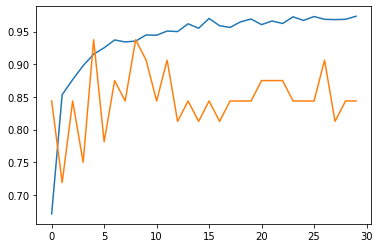

In [15]:
import matplotlib.pyplot as plt
plt.plot(acces)
plt.plot(acces_val)

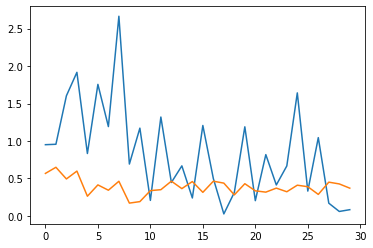

In [16]:
plt.plot(losses)
plt.plot(losses_val)

테스트셋의 정확도를 평가해봅시다. 

96% 수준의 정확도를 보였습니다. 

In [26]:
valid_loss = 0
valid_correct = 0

model.eval()  # 평가용 모드
with torch.no_grad(): 
  for x_val, y_val in test_loader:  # test set에서 정확도 평가
    x_val, y_val = x_val.to(device), y_val.to(device) 
    pred_val = model(x_val)
    valid_loss += loss_fn(pred_val, y_val).item()
    print(pred_val.shape, pred_val.argmax(1))
    valid_correct += (pred_val.argmax(1) == y_val).sum().item()
    print(valid_correct)

  valid_acc = valid_correct/(len(test_data)) # 데이터 개수로 나눔
  print(valid_correct)
  losses_val.append(valid_loss)
  acces_val.append(valid_acc)
  print(f"val_loss: {valid_loss:>7f}  val_acc:{valid_acc:>5f}")

torch.Size([32, 10]) tensor([8, 9, 7, 7, 5, 2, 2, 4, 7, 8, 1, 9, 3, 7, 6, 6, 9, 1, 2, 8, 6, 5, 7, 5,
        0, 3, 0, 6, 5, 6, 2, 4], device='cuda:0')
30
torch.Size([18, 10]) tensor([1, 8, 6, 1, 4, 4, 4, 3, 0, 2, 1, 9, 4, 0, 3, 8, 9, 5], device='cuda:0')
48
48
val_loss: 0.339748  val_acc:0.960000
